# Set-up

## Imports

In [1]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 200
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, f1_score, classification_report, matthews_corrcoef, PrecisionRecallDisplay
import joblib

## Parameters

In [43]:
scope = 'OFF'
model = 'GLM'
extension = '.csv'

input_path = f'../data/3_output/ML_dataset_{scope}.pkl'
predictions_path = f'{scope}/model_predictions/{model}_predicted_probs_monthly_recal_rolling_12m{extension}'

start_month = 201901
end_month = 202212

subsample_size = None

target = 'Result'

## Functions

In [44]:
def APS(groupby):
    return average_precision_score(groupby[target], groupby['y_probs'])

In [45]:
def get_APS_per_group(df, group, plot=True, plot_kind='bar', **kwargs):
    aps_df = df.groupby(group, as_index=False).apply(APS).rename({None: 'APS'}, axis=1)
    aps_df.sort_values(group, inplace=True)
    aps_df[group[0]] = aps_df[group[0]].astype(str)
    if plot:
        if len(group) > 1:
            aps_df.pivot(index=group[0], columns=group[1], values="APS").plot(kind='bar', **kwargs)
        else:
            aps_df.set_index(group[0]).plot(kind=plot_kind, legend=False, **kwargs)
        plt.xlabel(group[0])
        plt.xticks(rotation=0)
        plt.ylabel('Average Precision Score (APS)')
        plt.ylim((0,1))
        plt.title('{} bids APS per {}'.format(scope, group[0]))
        plt.savefig('../plots/{}/{}_aps_{}_{}.png'.format(scope, model, '_'.join(group), scope.lower()))
        plt.show()

    return aps_df

In [46]:
def get_acc_rate_per_group(df, group, plot=True, **kwargs):
    rate_df = df.groupby(group, as_index=False)["Result"].mean()
    rate_df[group[0]] = rate_df[group[0]].astype(str)
    if plot:
        if len(group) > 1:
            rate_df.pivot(index=group[0], columns=group[1], values="Result").plot(kind='bar', **kwargs)
        else:
            rate_df.set_index(group[0]).plot(kind='bar', legend=False, **kwargs)
        plt.xlabel(group[0])
        plt.xticks(rotation=0)
        plt.ylabel('Acceptance rate')
        plt.title('{} bids acceptance rate per {}'.format(scope, group[0]))
        plt.savefig('../plots/{}/{}_acc_{}_{}.png'.format(scope, model, '_'.join(group), scope.lower()))
        plt.show()

    return rate_df

# Main

## Load dataset & model predictions

In [47]:
# Load dataset
input_df = pd.read_pickle(input_path)
df = input_df.copy()
# Select only observations for which we generated a prediction
df['yearmonth'] = df.index.str[:6].astype(int)
df['month'] = df.index.str[4:6].astype(int)
df = df[(df.yearmonth >= start_month) & (df.yearmonth <= end_month)]
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,yearmonth,month
201901011UP_ACTV_1_OFF,1,20190101,2019,UP_ACTV_1,OFF,1.987508,-0.446966,-2.921364,-0.137306,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.436,False,201901,1
201901012UP_ACTV_1_OFF,2,20190101,2019,UP_ACTV_1,OFF,2.992812,0.367096,-3.134924,0.025819,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.475,False,201901,1
201901013UP_ACTV_1_OFF,3,20190101,2019,UP_ACTV_1,OFF,5.121951,-2.372232,-3.379947,0.027554,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.531,False,201901,1
201901014UP_ACTV_1_OFF,4,20190101,2019,UP_ACTV_1,OFF,3.023857,-0.063917,-3.585943,-0.011441,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.647,False,201901,1
201901015UP_ACTV_1_OFF,5,20190101,2019,UP_ACTV_1,OFF,3.785303,2.527202,-3.723609,0.051985,-0.401592,...,holiday,Vercelli,Thermoelectric,0.000,0.000,130.0,0.711,False,201901,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_OFF,17,20221231,2022,UP_VOGHERA_1,OFF,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,holiday,Pavia,Fossil Gas,0.540,0.540,320.0,0.066,False,202212,12
2022123121UP_VOGHERA_1_OFF,21,20221231,2022,UP_VOGHERA_1,OFF,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,...,holiday,Pavia,Fossil Gas,0.573,0.573,320.0,0.016,False,202212,12
2022123122UP_VOGHERA_1_OFF,22,20221231,2022,UP_VOGHERA_1,OFF,2.244316,-3.847872,-2.345759,0.833482,-2.547642,...,holiday,Pavia,Fossil Gas,0.526,0.526,320.0,0.085,False,202212,12
2022123123UP_VOGHERA_1_OFF,23,20221231,2022,UP_VOGHERA_1,OFF,2.277886,-3.849805,-2.698679,0.834434,-2.527069,...,holiday,Pavia,Fossil Gas,0.525,0.525,320.0,0.190,False,202212,12


In [48]:
# Load model predictions
if predictions_path.endswith('.csv'):
    y_probs = pd.read_csv(predictions_path, index_col=0)['y_probs']
else:
    y_probs = pd.read_pickle(predictions_path)
y_probs
# Below some obs could be dropped as NA as they were not in the prediction process
df['y_probs'] = y_probs
# We drop them
print(len(df))
df.dropna(subset=['y_probs'], inplace=True)
print(len(df))

2764499
2763261


## Performance analysis

### Overall performance per year

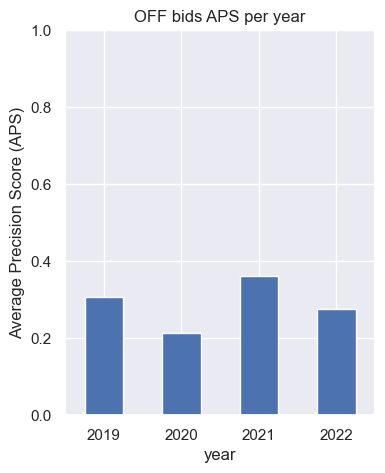

In [49]:
aps_df = get_APS_per_group(df, group=['year'], figsize=(4,5))

In [50]:
aps_df

,year,APS
0,2019,0.307789
1,2020,0.213809
2,2021,0.361761
3,2022,0.274767


### Overall performance per hour

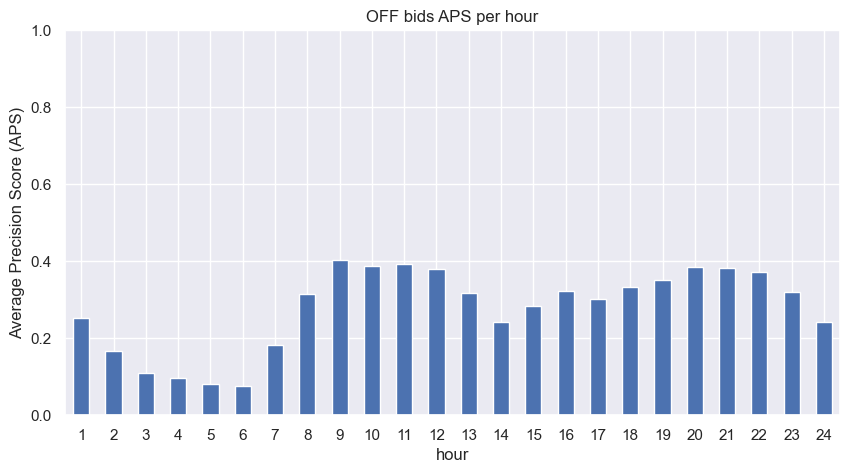

,hour,APS
0,1,0.253556
1,2,0.167735
2,3,0.110750
3,4,0.096611
4,5,0.081644
5,6,0.075073
6,7,0.182843
7,8,0.313993
8,9,0.402234
9,10,0.388650


In [51]:
aps_df = get_APS_per_group(df, group=['hour'], figsize=(10,5))
aps_df

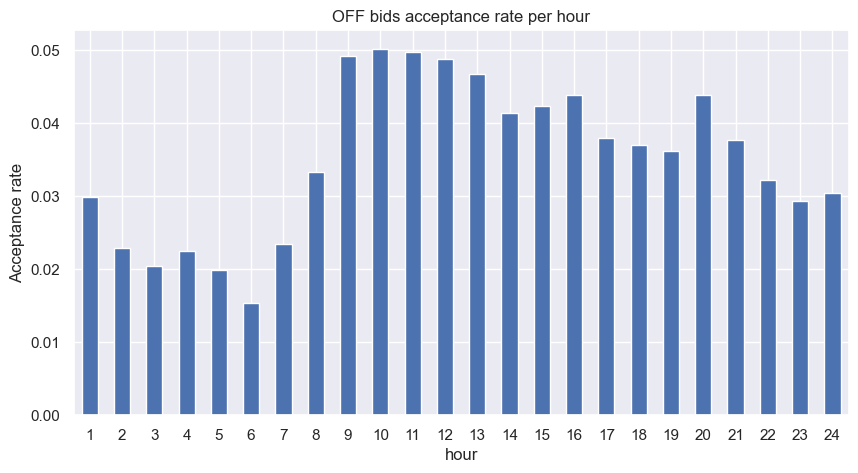

,hour,Result
0,1,0.029899
1,2,0.022926
2,3,0.020499
3,4,0.022548
4,5,0.019905
5,6,0.015409
6,7,0.023437
7,8,0.033356
8,9,0.049199
9,10,0.050198


In [52]:
acc_df = get_acc_rate_per_group(df, ["hour"], figsize=(10,5))
acc_df

So it seems that it is the acceptance rate that drives the variability in the performance of the model

### Overall performance per month

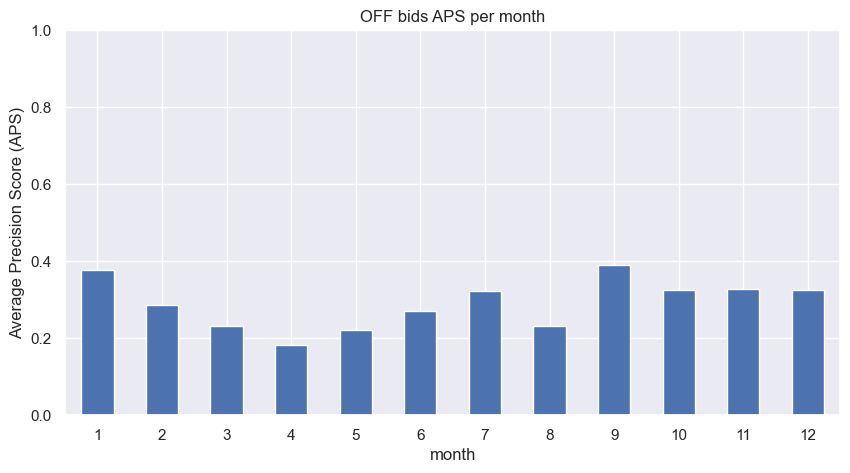

,month,APS
0,1,0.376537
1,2,0.287159
2,3,0.230572
3,4,0.183518
4,5,0.222529
5,6,0.270445
6,7,0.322634
7,8,0.230596
8,9,0.389455
9,10,0.324510


In [53]:
aps_df = get_APS_per_group(df, group=['month'], figsize=(10,5))
aps_df

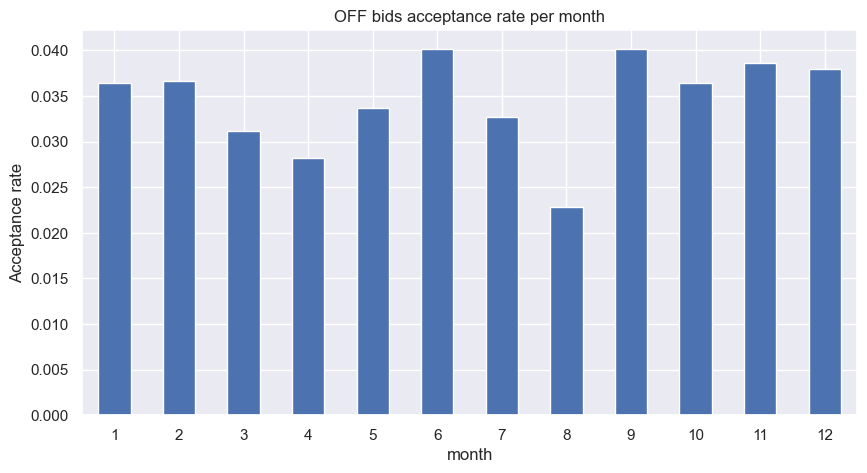

,month,Result
0,1,0.036406
1,2,0.036605
2,3,0.031193
3,4,0.028153
4,5,0.033721
5,6,0.040205
6,7,0.032693
7,8,0.022800
8,9,0.040181
9,10,0.036401


In [54]:
acc_df = get_acc_rate_per_group(df, ["month"], figsize=(10,5))
acc_df

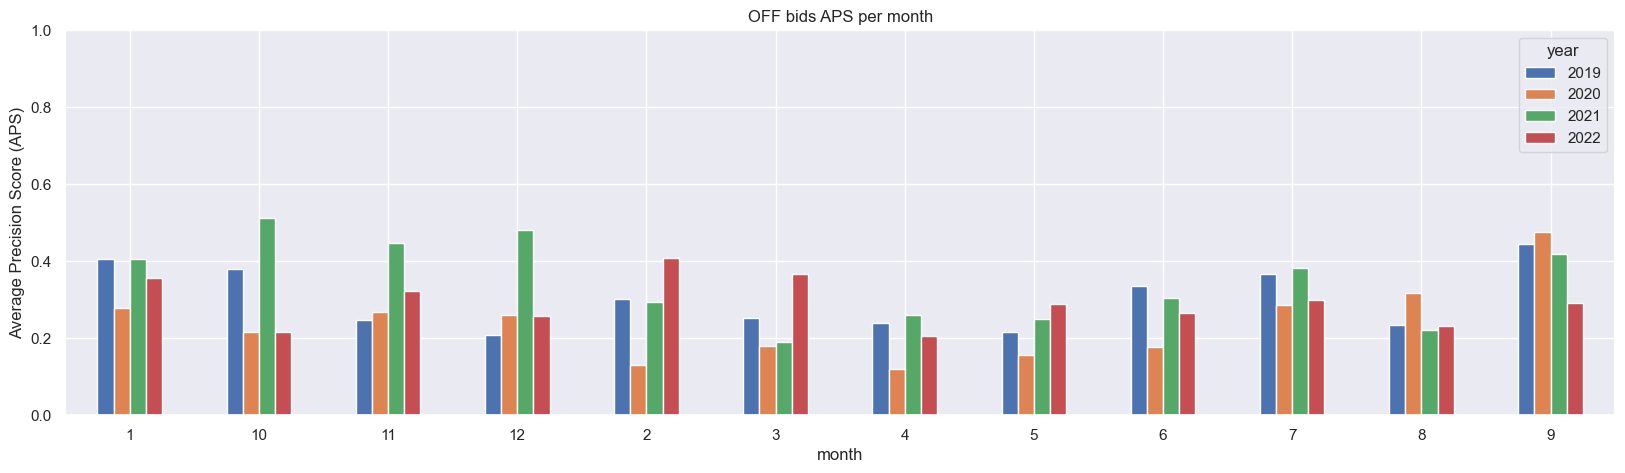

In [55]:
aps_df = get_APS_per_group(df, group=['month', 'year'], figsize=(20,5))

### Overall performance per technology

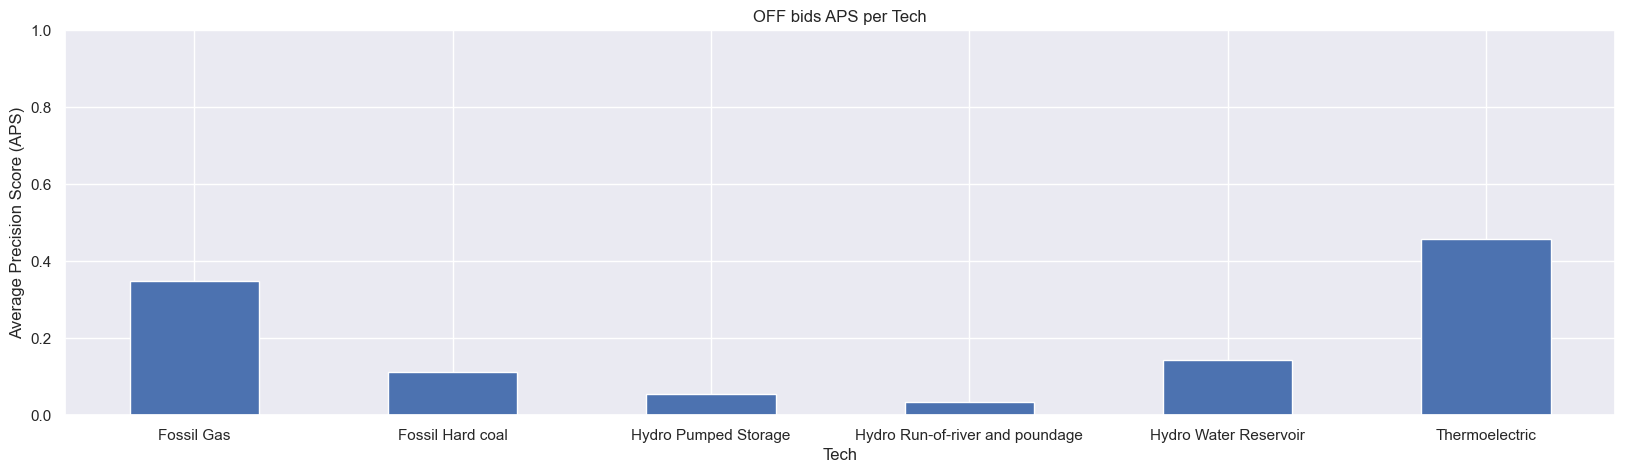

,Tech,APS
0,Fossil Gas,0.348712
1,Fossil Hard coal,0.111369
2,Hydro Pumped Storage,0.055266
3,Hydro Run-of-river and poundage,0.035328
4,Hydro Water Reservoir,0.143057
5,Thermoelectric,0.458905


In [56]:
aps_df = get_APS_per_group(df, group=['Tech'], figsize=(20,5))
aps_df

In [39]:
df.Tech.value_counts()

Tech
Fossil Gas                         618023
Hydro Pumped Storage               376357
Hydro Water Reservoir              356635
Hydro Run-of-river and poundage    190137
Thermoelectric                      70390
Fossil Hard coal                    34769
Name: count, dtype: int64

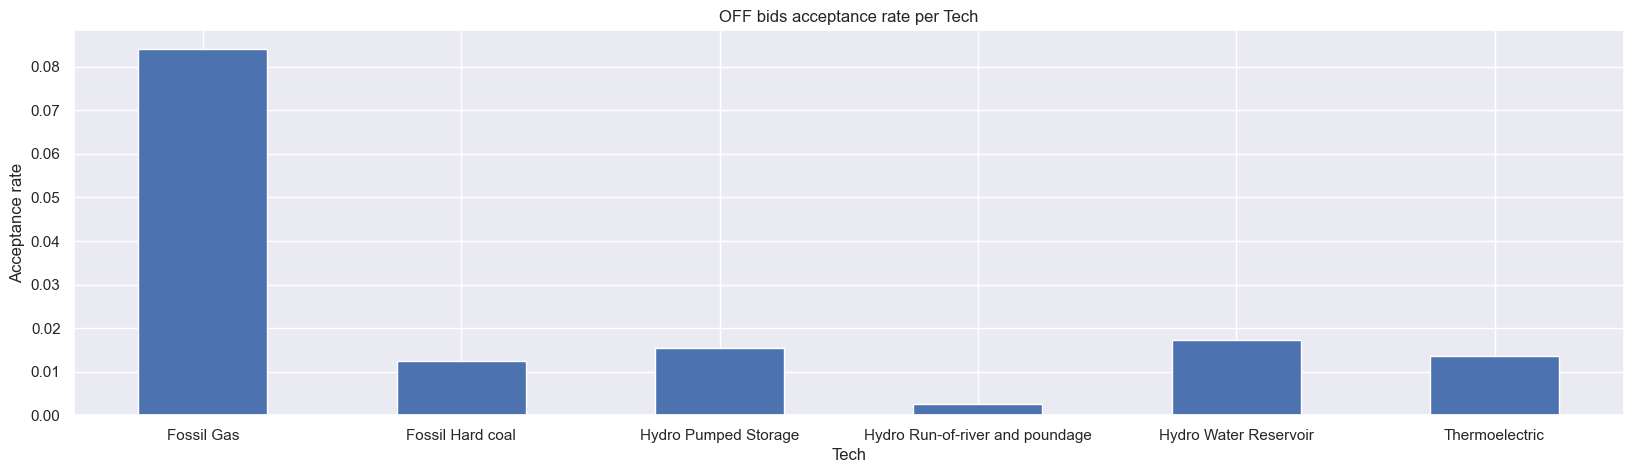

In [57]:
acc_df = get_acc_rate_per_group(df, ["Tech"], figsize=(20,5))

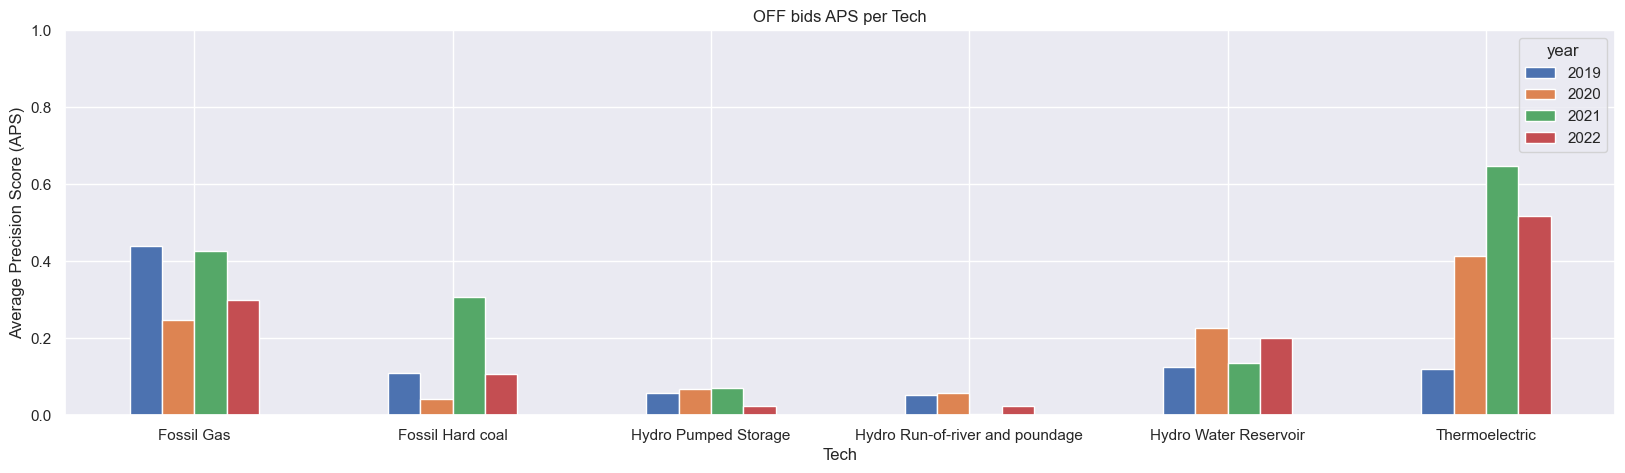

In [58]:
aps_df = get_APS_per_group(df, group=['Tech', 'year'], figsize=(20,5))

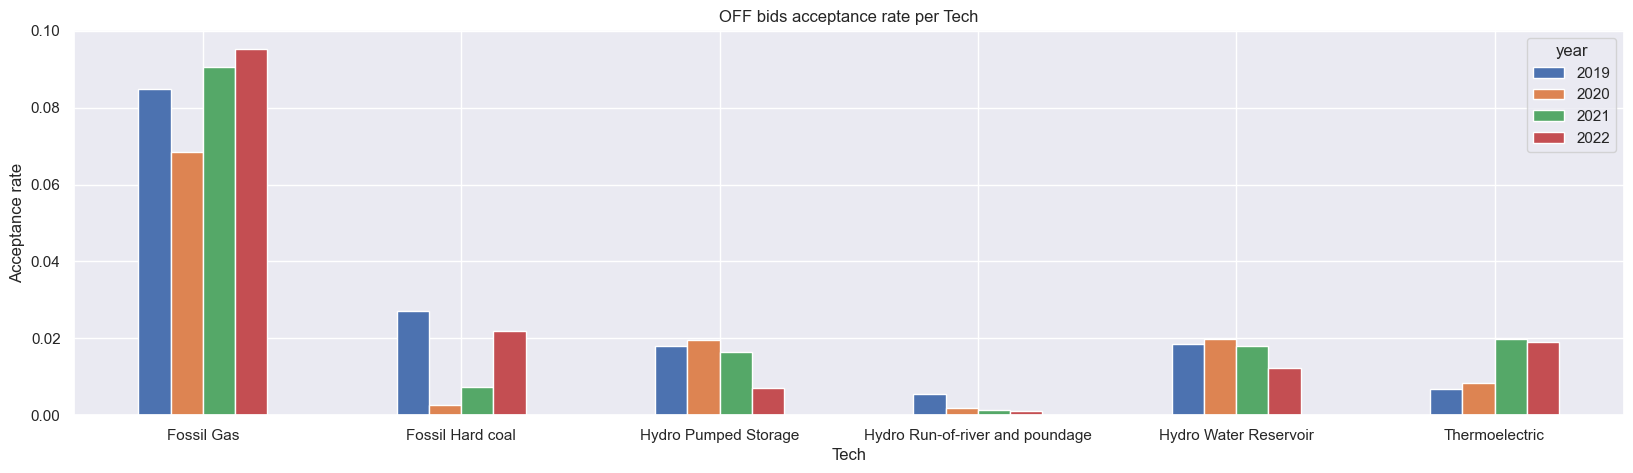

In [59]:
acc_df = get_acc_rate_per_group(df, ["Tech", "year"], figsize=(20,5))

### Time series of monthly performance

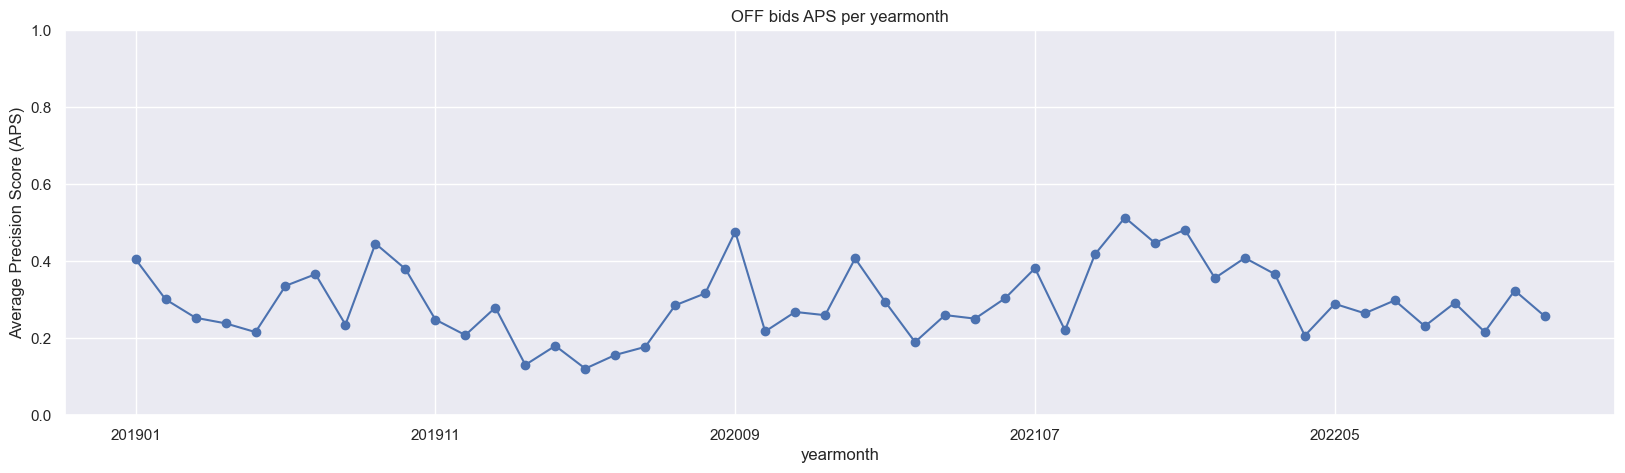

In [60]:
aps_df = get_APS_per_group(df, group=['yearmonth'], plot_kind='line', figsize=(20,5), marker='o')

In [42]:
input_df.to_csv(input_path.replace('.pkl', '.csv'))